In [1]:
!pip install striprtf

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import sys
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import random
from striprtf.striprtf import rtf_to_text

In [225]:
mapping = {
    "proxy": "доверенность",
    "contract": "договор",
    "act": "акт",
    "application": "заявление",
    "order": "приказ",
    "invoice": "счет",
    "bill": "приложение",
    "arrangement": "соглашение",
    "contract offer": "договор оферты",
    "statute": "устав",
    "determination": "решение",
}
etor = mapping
rtoe = {value: key for key, value in mapping.items()}

In [217]:
sample = pd.read_csv('../data/sample.csv')

In [78]:
sample

,class,text
0,arrangement,СОГЛАШЕНИЕ N 8\nо расторжении трудового догово...
1,arrangement,Соглашение о предоставлении опциона на заключе...
2,arrangement,Соглашение\nо реструктуризации задолженности\n...
3,arrangement,Дополнительное соглашение\r\nк договору купли-...
4,arrangement,Соглашение\nо расторжении договора об оказании...
...,...,...
496,bill,Счет № 5 от 01 октября 2020 г.\r\n\r\nПоставщи...
497,bill,Счет на оплату № от 14 октября 2020 года\r\n\r...
498,bill,Счет №23 от 12.09.2024 г.\t\t...
499,bill,"""Огурец!"" (ИП Микрюков В.В.)\t\t\t\t\t\t\r\n\t..."


In [6]:
sample['text'] = sample['text'].str.lower()

In [7]:
sample[
    (sample['text'].str.lower().str.contains('соглашение'))
    & 
    (sample['class'] != 'arrangement')
]

,class,text
166,proxy,д о в е р е н н о с т ь\nг. марс\nпервого янва...
171,proxy,д о в е р е н н о с т ь\nг. марс\nпервого янва...
173,contract,договор аутсорсинга it\nгород кемерово 14 дека...
179,contract,договор подряда на ремонт компьютера\nгород ке...
180,contract,договор подряда на уборку снега с крыш домов\n...
...,...,...
401,contract offer,договор публичной оферты\r\nнастоящий договор ...
403,contract offer,договор возмездного оказания услуг\r\n(публичн...
415,contract offer,публичная оферта (договор) на предоставление у...
433,invoice,\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...


In [8]:
i = random.randint(0, len(sample))
sample['text'][i]

'«утвержден»:\r\n решением единственного участника\r\nобщества с ограниченной ответственностью\r\n«плюсплюс»\r\nот «28» февраля 2022г.\r\nустав\r\nобщества с ограниченной ответственностью\r\n«плюсплюс»\r\nг. орск\r\n2022г.статья 1. общие положения\r\n1.1. общество с ограниченной ответственностью «плюсплюс», именуемое в дальнейшем\r\n"общество", является коммерческой организацией созданной его учредителем на неопределенный срок.\r\n1.2. общество создано в соответствии с гражданским кодексом российской федерации, федеральным законом "об обществах с ограниченной ответственностью" (далее "федеральный закон") и\r\nдругими законодательными актами.\r\n1.3. общество является юридическим лицом и строит свою деятельность на основании настоящего\r\nустава и действующего законодательства российской федерации.\r\n общество считается созданным как юридическое лицо с момента его государственной регистрации,\r\nв порядке установленном федеральным законом о государственной регистрации юридических лиц.\

In [9]:
sorted(mapping.items(), key=lambda x: x[0])

[('act', 'акт'),
 ('application', 'заявление'),
 ('arrangement', 'соглашение'),
 ('bill', 'приложение'),
 ('contract', 'договор'),
 ('contract offer', 'договор оферты'),
 ('determination', 'решение'),
 ('invoice', 'счет'),
 ('order', 'приказ'),
 ('proxy', 'доверенность'),
 ('statute', 'устав')]

In [10]:
sorted(sample['class'].unique().tolist())

['act',
 'application',
 'arrangement',
 'bill',
 'contract',
 'contract offer',
 'determination',
 'invoice',
 'order',
 'proxy',
 'statute']

In [11]:
def parse_rtf_file(file_path: str) -> str:
    """
    Parse rtf file to pure text
    
    :param file_path: path to rtf-file
    """
    
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    text = rtf_to_text(text)
    
    return text

In [12]:
mapping

{'proxy': 'доверенность',
 'contract': 'договор',
 'act': 'акт',
 'application': 'заявление',
 'order': 'приказ',
 'invoice': 'счет',
 'bill': 'приложение',
 'arrangement': 'соглашение',
 'contract offer': 'договор оферты',
 'statute': 'устав',
 'determination': 'решение'}

In [20]:
def parse_folders() -> pd.DataFrame:

    folders = [
        ('Уставы', 'statute'),
        ('Соглашения', 'arrangement'),
        ('Приказы', 'order'),
        ('Заявления', 'application'),
        ('Договоры', 'contract'),
    ]

    folders_df = []

    for folder in folders:
        ru_name, class_ = folder

        texts = []

        for file_path in tqdm(glob.glob(f'../data/{ru_name}/*')):
            text = parse_rtf_file(file_path)
            texts.append(text)

        folder_df = pd.DataFrame({
            'class': class_,
            'text': texts,
        })

        folders_df.append(folder_df)

    folders_df = pd.concat(folders_df)
    
    return folders_df

100%|█████████████████████████████████████████| 108/108 [00:12<00:00,  8.78it/s]


In [30]:
folders_df = folders_df.reset_index(drop=True)
folders_df.to_csv('from_folders.csv', index=False)

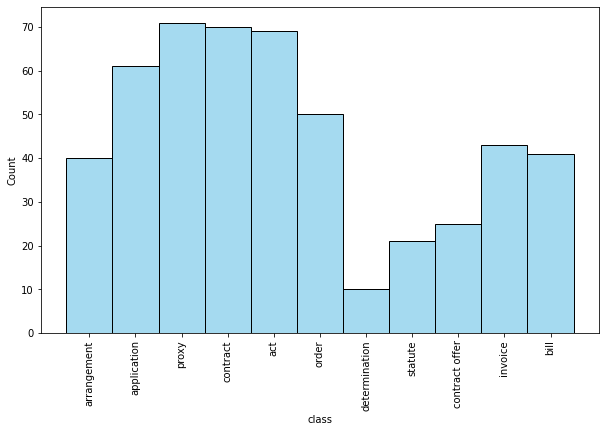

In [40]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=sample, x='class', bins=11, color='skyblue'
)
plt.xticks(rotation=90)
plt.show()

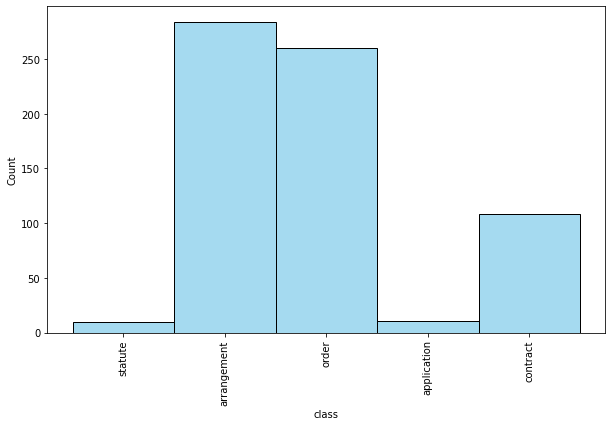

In [41]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=folders_df, x='class', bins=11, color='skyblue'
)
plt.xticks(rotation=90)
plt.show()

In [65]:
sample[
    sample['text'].str.contains('о премировании')
]['text'].values

array(['ооо «напольное покрытие»\r\nприказ №88\r\n29.04.2021 года\r\nо премировании\r\nна основании пункта 23 положения о премировании №47-а, с учетом достигнутого отделом годового плана продаж:\r\n1. назначить гендиректору ооо «напольного покрытия» громову в.а. премию в размере 50% от оклада.\r\n2. главбуху ивановой о.о. начислить вознаграждение в срок до 10.05.2021 года.\r\n3. контроль над выполнением настоящего распоряжения возложить на главбуха иванову о.о.\r\nруководитель: семенов о.л. (подпись)\r\nс приказом ознакомлены:\r\nгромов в.а. (подпись)\r\nиванова о.о. (подпись)\r\n\r'],
      dtype=object)

In [52]:
sample['class'].value_counts()

proxy             71
contract          70
act               69
application       61
order             50
invoice           43
bill              41
arrangement       40
contract offer    25
statute           21
determination     10
Name: class, dtype: int64

In [58]:
sample['class'][6]

'arrangement'

In [238]:
import re
import pandas as pd


replace_words = {
    "доверенность" : re.compile(r"\bд\s*о\s*в\s*е\s*р\s*е\s*н\s*н\s*о\s*с\s*т\s*ь\b"),
    "договор" : re.compile(r"\bд\s*о\s*г\s*о\s*в\s*о\s*р\b"),
    "акт": re.compile(r"\bа\s*к\s*т\b"),
    "заявление": re.compile(r"\bз\s*а\s*я\s*в\s*л\s*е\s*н\s*и\s*е\b"),
    "приказ": re.compile(r"\bп\s*р\s*и\s*к\s*а\s*з\b"),
    "счет": re.compile(r"\bс\s*ч\s*е\s*т\b"),
    "приложение": re.compile(r"\bп\s*р\s*и\s*л\s*о\s*ж\s*е\s*н\s*и\s*e\b"),
    "соглашение": re.compile(r"\bс\s*о\s*г\s*л\s*а\s*ш\s*е\s*н\s*и\s*e\b"),
    "договор оферты": re.compile(r"\bд\s*о\s*г\s*о\s*в\s*о\s*р\s*о\s*ф\s*е\s*р\s*т\s*ы\b"),
    "устав": re.compile(r"\bу\s*с\s*т\s*а\s*в\b"),
    "решение": re.compile(r"\bр\s*е\s*ш\s*е\s*н\s*и\s*е\b")
}


def clean_text(text: str)->str:
    for key, value in replace_words.items():
        text = re.sub(value, key, text)

    # Удаление цифр, символов, табуляций и символов окончания строки
    text = re.sub(r'[^а-яА-Яa-zA-Z\s<]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Удаление слов с длиной меньше одной буквы
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)

    return text


def data_processing(df: pd.DataFrame) -> pd.DataFrame:
    df_ = df.copy()
    df_['text'] = df_['text'].str.lower()
    df_['text'] = df_['text'].apply(clean_text)
    return df_

In [84]:
data_processing(sample)

,class,text
0,arrangement,соглашение расторжении трудового договора от к...
1,arrangement,соглашение предоставлении опциона на заключени...
2,arrangement,соглашение реструктуризации задолженности ижев...
3,arrangement,дополнительное соглашение договору куплипродаж...
4,arrangement,соглашение расторжении договора об оказании ус...
...,...,...
496,bill,счет от октября поставщик иванова нина игоревн...
497,bill,счет на оплату от октября года поставщик ип ив...
498,bill,счет от поставщик ооо асистемс инн кпп адрес с...
499,bill,огурец ип микрюков вв адрес ижевск ая образец ...


In [72]:
folders_df

,class,text
0,statute,утверждено на учредительной конференции предст...
1,statute,министерство обороны российской федерации кора...
2,statute,введен действие приказом министра обороны росс...
3,statute,принят учредительным съездом профсоюзов рсфср ...
4,statute,утвержден всероссийским съездом адвокатов янва...
...,...,...
668,contract,договор товарных знаках знаках обслуживания на...
669,contract,договор от января года между российской федера...
670,contract,центральный банк российской федерации приложен...
671,contract,договор от июня года союза советских социалист...


In [79]:
sample.sample(5)['text'].values

array(['Директору ООО «Электра»\nНикодимову Артему Филипповичу\nот менеджера\nСупруновой Маргариты Петровны\n\nзаявление.\n\nПрошу предоставить мне отпуск по уходу за ребенком до 1,5 лет (дочь Супрунова Мария Ильинична родилась 3.04.19 г.) с 13 июня 2019 года. Прошу производить расчет и выплачивать мне ежемесячное пособие по уходу за ребенком до 1,5 лет на счет зарплатной карты.\nПриложения:\n\nкопия свидетельства о рождении дочери Супруновой М.И.,\nсправка с места работы мужа, о том, то он не находится в отпуске по уходу за ребенком и не получает ежемесячное пособие.\n13.06.19 г.\n\nСупрунова М.П.',
       'Договор аутсорсинга IT\nГород Кемерово 14 декабря 2023 года\nООО «Программ Плюс», в лице исполняющего обязанности генерального директора общества Иванова Петра Максимовича, действующего в соответствии с Уставом общества, именуемый в дальнейшем «Исполнитель», с одной стороны\nи\nИП Максименко, в лице индивидуального предпринимателя Максименко Дмитрия Анатольевича, паспортные данные:

In [112]:
parse_links = {
    'доверенность': 'https://assistentus.ru/forma/doverennost/',
    'договор': 'https://assistentus.ru/forma/dogovor/',
    'акт': 'https://assistentus.ru/forma/akt/',
    'заявление': 'https://assistentus.ru/forma/zayavlenie/',
    'приказ': 'https://assistentus.ru/forma/prikaz/',
#     'счет': '????',
#     'приложение': '???',
    'соглашение': 'https://assistentus.ru/forma/soglashenie/',
#     'договор оферты': '???',
#     'устав': '???',
    'решение': 'https://assistentus.ru/forma/reshenie/'
}

In [114]:
result = {}

for class_ in tqdm(parse_links):
    
    html = requests.get(parse_links[class_]).text
    soup = BeautifulSoup(html, 'html.parser')
    div_list = soup.find('div', class_='list')
    links = [i.get('href') for i in div_list.find_all('a')]
    
    files = []
    for link in tqdm(links):
        html_ = requests.get(link).text
        soup_ = BeautifulSoup(html_, 'html.parser')
        try:
            file = [i for i in soup_.find('p', class_='hl_files').find_all('a') if 'образец' in i.text][0]
        except IndexError:
            continue
        files.append(file)

    files = [file.get('href') for file in files]
    
    result[class_] = files

  9%|███▋                                      | 59/675 [00:57<09:56,  1.03it/s]


 23%|█████████▍                               | 156/675 [03:09<06:26,  1.34it/s]


 37%|███████████████▎                         | 253/675 [04:24<05:01,  1.40it/s]


 52%|█████████████████████▎                   | 350/675 [05:36<03:33,  1.52it/s]


 66%|███████████████████████████▏             | 447/675 [06:47<02:46,  1.37it/s]


 81%|█████████████████████████████████        | 544/675 [07:55<01:40,  1.30it/s]


 95%|██████████████████████████████████████▉  | 641/675 [09:02<00:22,  1.49it/s]


 22%|█████████                                 | 61/283 [00:44<02:30,  1.47it/s]


 56%|██████████████████████▉                  | 158/283 [01:51<01:22,  1.51it/s]


 90%|████████████████████████████████████▉    | 255/283 [02:58<00:18,  1.53it/s]


 26%|███████████                               | 67/254 [00:47<02:08,  1.46it/s]


 65%|██████████████████████████▍              | 164/254 [01:53<01:01,  1.46it/s]


  2%|▊                                          | 5/276 [00:04<03:48,  1.19it/s]


 37%|███████████████▏                         | 102/276 [01:12<01:59,  1.45it/s]


 72%|█████████████████████████████▌           | 199/276 [02:22<00:55,  1.39it/s]


 53%|██████████████████████▊                    | 18/34 [00:13<00:11,  1.39it/s]


100%|████████████████████████████████████████████| 7/7 [19:54<00:00, 170.59s/it]


In [126]:
additional_links = []

for class_, links in result.items():
    additional_links_df = pd.DataFrame({
        'class': rtoe[class_],
        'link': links,
    })
    
    additional_links.append(additional_links_df)

additional_links = pd.concat(additional_links)

In [130]:
additional_links.to_csv('../data/additional_links.csv', index=False)

In [70]:
additional_links = pd.read_csv('../data/additional_links.csv')
additional_links

,class,link
0,proxy,https://assistentus.ru/wp-content/uploads/file...
1,proxy,https://assistentus.ru/wp-content/uploads/file...
2,proxy,https://assistentus.ru/wp-content/uploads/file...
3,proxy,https://assistentus.ru/wp-content/uploads/file...
4,proxy,https://assistentus.ru/wp-content/uploads/file...
...,...,...
1552,determination,https://assistentus.ru/wp-content/uploads/file...
1553,determination,https://assistentus.ru/wp-content/uploads/file...
1554,determination,https://assistentus.ru/wp-content/uploads/file...
1555,determination,https://assistentus.ru/wp-content/uploads/file...


In [66]:
additional_links.to_csv('tmp.csv', index=False)

In [183]:
docx_files = glob.glob('../data/tmp/*.docx')

In [188]:
res = {}
for file in tqdm(docx_files):
    try:
        res[file] = docx2txt.process(file)
    except Exception as e:
        print(e)

 10%|███▊                                   | 144/1457 [00:00<00:03, 330.94it/s]

File is not a zip file


100%|██████████████████████████████████████| 1457/1457 [00:05<00:00, 284.63it/s]


In [193]:
res = pd.DataFrame(res.items(), columns=['path', 'text'])

In [199]:
res['path'] = res['path'].str.split('/', expand=True)[3].str.split('.', expand=True)[0]

In [200]:
res

,path,text
0,obrazec-iskovoe-zayavlenie-v-arbitrajniy-sud,25 ноября 2024 года\n\n\nВ Арбитражный суд Тюм...
1,obrazec-akt-peredachi-toplivnoy-karti-voditelu,ООО «Логистические услуги всем»\n\nАкт приема-...
2,obrazec-zayavlenie-o-perevode-v-drugoi-klass,Директору МБОУ СОШ № 19 г. Кургана Нестерову С...
3,obrazec-dogovora-podrjada-na-stroitel'stvo-saraja,Преамбула\n\nДоговор подряда на строительство ...
4,obrazec-doverennost-na-registracziyu-ts-v-gibd...,Доверенность\n\n\n\nг. Ижевск\n\nДата выдачи: ...
...,...,...
1451,obrazec-dogovora-arendy-stroitel'nogo-pylesosa,Договор аренды строительного пылесоса\n\nг. Вл...
1452,obrazec-dogovora-podrjada-na-remont-kofemashiny,Преамбула\n\nДоговор подряда на ремонт кофемаш...
1453,obrazec-dogovora-na-tehnicheskoe-obsluzhivanie...,Преамбула\n\nДоговор на техническое обслуживан...
1454,obrazec-dogovora-lichnogo-strahovanija,Преамбула\n\nДоговор личного страхования\n\nГо...


In [207]:
additional_links['path'] = additional_links['link'].str.split('/', expand=True)[6].str.split('.', expand=True)[0]

In [212]:
additional_links.merge(res, how='inner').to_csv('../data/external_data.csv', index=False)

In [222]:
pd.concat([
    pd.read_csv('../data/external_data.csv')[['class', 'text']],
    sample
])

,class,text
0,proxy,Доверенность\n\n\n\nг. Ижевск\n\nДата выдачи: ...
1,proxy,"ООО ""Артемида""\n\n426000, г. Ижевск, ул. Сосно..."
2,proxy,"Общество с ограниченной ответственностью ""Сигм..."
3,proxy,Доверенность\n\n\n\n\n\n\n\nг. Ижевск\n\nДвадц...
4,proxy,Доверенность\n\n\n\nг. Ижевск\n\n\n\nтринадцат...
...,...,...
496,bill,Счет № 5 от 01 октября 2020 г.\r\n\r\nПоставщи...
497,bill,Счет на оплату № от 14 октября 2020 года\r\n\r...
498,bill,Счет №23 от 12.09.2024 г.\t\t...
499,bill,"""Огурец!"" (ИП Микрюков В.В.)\t\t\t\t\t\t\r\n\t..."


In [236]:
pd.read_csv('../data/external_data.csv')[['class', 'text']].loc[1, :]['text']

'ООО "Артемида"\n\n426000, г. Ижевск, ул. Сосновая, д. 12А, тел. (3412) 44-44-44\n\nОГРН 223344556677, ИНН 5617894563, КПП 77665544332\n\n\n\nДоверенность\n\n\n\nГород Ижевск\n\n\n\nдвадцать третье ноября две тысячи девятнадцатого года\n\n\n\nОбщество с ограниченной ответственностью "Артемида" (ООО "Артемида"), юр.адрес: 426000, г. Ижевск, ул. Сосновая, д. 12А, тел. (3412) 44-44-44, ОГРН 223344556677, ИНН 5617894563, КПП 77665544332, в лице генерального директора Демидова Петра Петровича, действующего на основании Устава, данной доверенностью уполномачивает руководителя отдела делопроизводства Семенову Ирину Романовну, 12.09.1977 г.р., паспорт серия 9000 №112233, выдан 16.12.2003 г. Индустриальным РОВД г. Ижевска, зарегистрированную по адресу г. Ижевск, ул. Елочная, д. 123А, кв. 14, заверять своей подписью и печатью ООО "Артемида" копии документов, подлинники которых находятся в ООО "Артемида", согласно порядку, утвержденному действующим законодательством РФ.\n\n\n\nНастоящая доверенно

In [235]:
sample[
    sample['class'] == 'proxy'
].loc[137, :]['text']

'ООО "Артемида"\n426000, г. Ижевск, ул. Сосновая, д. 12А, тел. (3412) 44-44-44\nОГРН 223344556677, ИНН 5617894563, КПП 77665544332\n\nДоверенность\n\nГород Ижевск\n\nдвадцать третье ноября две тысячи девятнадцатого года\n\nОбщество с ограниченной ответственностью "Артемида" (ООО "Артемида"), юр.адрес: 426000, г. Ижевск, ул. Сосновая, д. 12А, тел. (3412) 44-44-44, ОГРН 223344556677, ИНН 5617894563, КПП 77665544332, в лице генерального директора Демидова Петра Петровича, действующего на основании Устава, данной доверенностью уполномачивает руководителя отдела делопроизводства Семенову Ирину Романовну, 12.09.1977 г.р., паспорт серия 9000 №112233, выдан 16.12.2003 г. Индустриальным РОВД г. Ижевска, зарегистрированную по адресу г. Ижевск, ул. Елочная, д. 123А, кв. 14, заверять своей подписью и печатью ООО "Артемида" копии документов, подлинники которых находятся в ООО "Артемида", согласно порядку, утвержденному действующим законодательством РФ.\n\nНастоящая доверенность выдана сроком на 3 г

In [241]:
process(pd.read_csv('../data/external_data.csv'))

NameError: name 'process' is not defined